In [1]:
import numpy as np

class RPNode:
    def __init__(self, projection_vector=None, threshold=None, left=None, right=None, points=None):
        # Random projection vector used for splitting
        self.projection_vector = projection_vector
        # Threshold value for splitting
        self.threshold = threshold
        # Left and right child nodes
        self.left = left
        self.right = right
        # If this is a leaf node, it stores the actual data points (pixel blocks)
        self.points = points


In [3]:
def random_projection(dimensions):
    # Create a random vector of size equal to the number of dimensions in the data
    vector = np.random.randn(dimensions)
    # Normalize the vector so it has unit length
    vector = vector / np.linalg.norm(vector)
    return vector


In [4]:
def build_rp_tree(data, max_leaf_size=10):
    # If the number of points is small enough, make this a leaf node
    if len(data) <= max_leaf_size:
        return RPNode(points=data)
    
    # Get the number of dimensions in the data (e.g., 27D or 36D pixel blocks)
    dimensions = data.shape[1]
    
    # Create a random projection vector
    projection_vector = random_projection(dimensions)
    
    # Project all points onto the random vector
    projected_data = np.dot(data, projection_vector)
    
    # Choose a threshold (median) to split the data
    threshold = np.median(projected_data)
    
    # Split the data into two groups based on the threshold
    left_data = data[projected_data <= threshold]
    right_data = data[projected_data > threshold]
    
    # Recursively build the left and right subtrees
    left_child = build_rp_tree(left_data, max_leaf_size)
    right_child = build_rp_tree(right_data, max_leaf_size)
    
    # Return a node with the projection vector, threshold, and children
    return RPNode(projection_vector=projection_vector, threshold=threshold, left=left_child, right=right_child)


In [5]:
from heapq import heappush, heappop

def knn_search(node, query_point, k, neighbors):
    # If we reach a leaf node, check all points in this node
    if node.points is not None:
        for point in node.points:
            # Calculate the distance between the query and the current point
            distance = np.linalg.norm(query_point - point)
            # Add the point and its distance to the list of neighbors
            heappush(neighbors, (-distance, point))
            # If we have more than k neighbors, remove the farthest one
            if len(neighbors) > k:
                heappop(neighbors)
        return
    
    # Otherwise, project the query point onto the random projection vector
    projected_value = np.dot(query_point, node.projection_vector)
    
    # Recursively search the left or right subtree depending on the threshold
    if projected_value <= node.threshold:
        knn_search(node.left, query_point, k, neighbors)
        # After searching the main side, check the other side if needed
        if len(neighbors) < k or -neighbors[0][0] > abs(projected_value - node.threshold):
            knn_search(node.right, query_point, k, neighbors)
    else:
        knn_search(node.right, query_point, k, neighbors)
        if len(neighbors) < k or -neighbors[0][0] > abs(projected_value - node.threshold):
            knn_search(node.left, query_point, k, neighbors)

def get_knn(tree, query_point, k):
    neighbors = []
    knn_search(tree, query_point, k, neighbors)
    return [point for _, point in sorted(neighbors, reverse=True)]


In [6]:
import time

def experiment_with_data_size(sizes=[1000, 10000, 100000]):
    for size in sizes:
        # Generate random data of different sizes and dimensions
        data = np.random.rand(size, 36)  # 36D pixel blocks
        query_point = np.random.rand(36)
        
        # Test RP-tree
        start_time = time.time()
        rp_tree = build_rp_tree(data)
        indexing_time = time.time() - start_time
        
        # Test search with RP-tree
        start_time = time.time()
        neighbors_rp = get_knn(rp_tree, query_point, k=5)
        rp_search_time = time.time() - start_time
        
        # Test brute-force search
        start_time = time.time()
        distances = np.linalg.norm(data - query_point, axis=1)
        nearest_indices = np.argsort(distances)[:5]
        brute_force_search_time = time.time() - start_time
        
        print(f"Data size: {size}")
        print(f"RP-tree indexing time: {indexing_time:.6f} seconds")
        print(f"RP-tree search time: {rp_search_time:.6f} seconds")
        print(f"Brute-force search time: {brute_force_search_time:.6f} seconds")
        print()


In [7]:
def experiment_with_dimensionality(dimensions=[10, 36, 100]):
    for dim in dimensions:
        # Generate random data with different dimensions
        data = np.random.rand(10000, dim)  # 10,000 points with varying dimensions
        query_point = np.random.rand(dim)
        
        # Test RP-tree
        start_time = time.time()
        rp_tree = build_rp_tree(data)
        indexing_time = time.time() - start_time
        
        # Test search with RP-tree
        start_time = time.time()
        neighbors_rp = get_knn(rp_tree, query_point, k=5)
        rp_search_time = time.time() - start_time
        
        # Test brute-force search
        start_time = time.time()
        distances = np.linalg.norm(data - query_point, axis=1)
        nearest_indices = np.argsort(distances)[:5]
        brute_force_search_time = time.time() - start_time
        
        print(f"Dimensions: {dim}")
        print(f"RP-tree indexing time: {indexing_time:.6f} seconds")
        print(f"RP-tree search time: {rp_search_time:.6f} seconds")
        print(f"Brute-force search time: {brute_force_search_time:.6f} seconds")
        print()


In [8]:
from scipy.spatial.distance import cdist

def experiment_with_distance_metrics(metric='euclidean'):
    # Generate random data and a query point
    data = np.random.rand(10000, 36)
    query_point = np.random.rand(36)
    
    # Test RP-tree with different distance metrics
    start_time = time.time()
    rp_tree = build_rp_tree(data)
    indexing_time = time.time() - start_time
    
    # Perform brute-force search using different distance metrics
    start_time = time.time()
    distances = cdist([query_point], data, metric=metric).flatten()
    nearest_indices = np.argsort(distances)[:5]
    brute_force_search_time = time.time() - start_time
    
    print(f"Distance metric: {metric}")
    print(f"Brute-force search time: {brute_force_search_time:.6f} seconds")


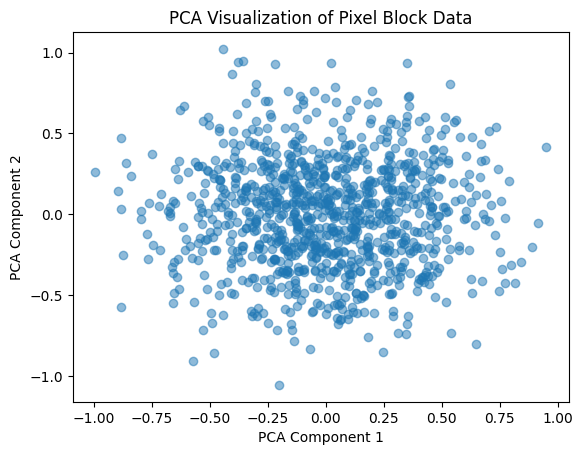

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def visualize_with_pca(data):
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data)
    
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], alpha=0.5)
    plt.title('PCA Visualization of Pixel Block Data')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

# Example usage
data = np.random.rand(1000, 36)  # 1,000 pixel blocks with 36D
visualize_with_pca(data)


Which methods were fastest for different dataset sizes, and how well the RP-tree handled increasing dimensions.
The effect of distance metrics and how they impacted the search speed and quality of the nearest neighbors.
Whether visualization techniques like PCA revealed any useful structure in the data.
Your favorite method (e.g., RP-tree or brute-force) and in what scenarios you would prefer one over the other.